# Proyecto C - Caso 2

Estudiantes: 

1. Mariana Lozano Roncancio 202122878

# A. Presentaccion de modelo 

A continuacion se presenta el modlo con las siguientes cambios realizados:

- Adición de restricciones de continuidad y consumo de combustible.
- Inclusión de variables auxiliares para orden y combustible restante.
- Restricciones MTZ para evitar subtours.
- Inclusión de la restricción de visita única a cada cliente.
- Reorganización del modelo para mejorar su claridad y consistencia.

## 1. Conjuntos

- **P**: Conjunto de puntos de acceso (puertos)
- **D**: Conjunto de destinos (centros de consumo)
- **E**: Conjunto de estaciones de recarga
- **V**: Conjunto de vehículos
- **N**: Conjunto total de nodos, `N = P ∪ D ∪ E`
- **A**: Conjunto de arcos posibles, `A = {(i, j) ∈ N × N | i ≠ j}`

# 2. Parámetros
- `d_ij`: Distancia entre nodos i y j
- `C_ij`: Costo base entre nodos i y j
- `M_v`: Capacidad útil del vehículo v
- `A_v`: Autonomía del vehículo v
- `R_v`: Rendimiento (km/gal) del vehículo v
- `L_j`: Límite de peso en el nodo j
- `P_s`: Precio de galón en estación s
- `F_t`: Tarifa de flete (COP/km)
- `C_m`: Costo de mantenimiento (COP/km)
- `E_v`: Penalización por CO₂ por km para el vehículo v
- `T_ij`: Peaje base en tramo i → j
- `T2_ij`: Peaje adicional por tonelada
- `demand_j`: Demanda en el nodo j


## 3. Variables de decisión
- `x_ijv ∈ {0,1}`: 1 si el vehículo v viaja de i a j
- `q_ijv ≥ 0`: Carga transportada entre i y j por v
- `z_ijv ≥ 0`: Variable auxiliar para `q * x`
- `f_ijv ≥ 0`: Combustible consumido entre i y j
- `r_sv ≥ 0`: Galones recargados en la estación s por v
- `y_sv ∈ {0,1}`: 1 si v recarga en estación s
- `u_iv ≥ 0`: Orden de visita del nodo i por v
- `comb_iv ≥ 0`: Combustible restante en i por v

## 4. Función Objetivo

Minimizar el costo total de operación:

$$
\min \sum_v \sum_{(i,j)} \left( 
C_{ij} \cdot x_{ijv} + 
F_t \cdot d_{ij} \cdot x_{ijv} + 
C_m \cdot d_{ij} \cdot x_{ijv} + 
T_{ij} \cdot x_{ijv} + 
T2_{ij} \cdot z_{ijv} + 
E_v \cdot d_{ij} \cdot x_{ijv} 
\right) + \sum_v \sum_s P_s \cdot r_{sv}
$$


##  Restricciones

### 1. Conservación de flujo

$$
\sum_{j \in N, j \ne n} x_{jnv} = \sum_{j \in N, j \ne n} x_{njv}
\quad \forall n \in N, \forall v \in V
$$



### 2. Capacidad del vehículo

$$
q_{ijv} \le M_v \cdot x_{ijv}
\quad \forall (i,j) \in A, \forall v \in V
$$



### 3. Límite de peso por municipio

$$
q_{ijv} \le L_j
\quad \forall (i,j) \in A, j \in D, \forall v \in V
$$



### 4. Consumo de combustible

$$
f_{ijv} = \frac{d_{ij}}{R_v} \cdot x_{ijv}
\quad \forall (i,j) \in A, \forall v \in V
$$



### 5. Continuidad del combustible

$$
comb_{jv} = comb_{iv} - f_{ijv} + r_{jv}
\quad \forall (i,j) \in A, \forall v \in V
$$



### 6. Recarga en estación activa

$$
r_{sv} \le M \cdot y_{sv}
\quad \forall s \in E, \forall v \in V
$$



### 7. Eliminación de subtours (MTZ)

$$
u_{iv} - u_{jv} + |D| \cdot x_{ijv} \le |D| - 1
\quad \forall i \ne j \in D, \forall v \in V
$$



### 8. Satisfacción de la demanda

$$
\sum_{i \in N, i \ne j} \sum_{v \in V} q_{ijv} \ge demand_j
\quad \forall j \in D
$$



### 9. Linealización de \( z = q \cdot x \)

$$
\begin{aligned}
z_{ijv} &\le q_{ijv} \\
z_{ijv} &\le M_v \cdot x_{ijv} \\
z_{ijv} &\ge q_{ijv} - M_v \cdot (1 - x_{ijv})
\end{aligned}
$$

# B. Presentacion de Notebook ejecutado

In [28]:
!apt-get install -y coinor-cbc
!pip install pyomo


'apt-get' is not recognized as an internal or external command,
operable program or batch file.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\MarianaLozano\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [29]:
import pandas as pd
import numpy as np
import pyomo.environ as pyo
from pyomo.environ import *

# === Cargar datos ===
clients = pd.read_csv("Datos/clients2.csv")
depots = pd.read_csv("Datos/depots2.csv")
stations = pd.read_csv("Datos/stations2.csv")
vehicles = pd.read_csv("Datos/vehicles2.csv")

# === Conjuntos ===
V = list(vehicles['VehicleID'])
D = list(clients['LocationID'])    # Municipios
P = list(depots['DepotID'])        # Puerto
S = list(stations['EstationID'])   # Estaciones de recarga
N = P + D + S                      # Todos los nodos

# Crear mapeo automático: índice (1,2,3,...) -> nombre real
node_name_map = {str(idx + 1): node for idx, node in enumerate(N)}

# === Parámetros ===
Q = dict(zip(vehicles['VehicleID'], vehicles['Capacity']))             # Capacidad de carga (kg)
Range = dict(zip(vehicles['VehicleID'], vehicles['Range']))            # Autonomía máxima (km)
Demand = dict(zip(clients['LocationID'], clients['Demand']))           # Demanda de cada municipio
FuelPrice = dict(zip(stations['EstationID'], stations['FuelCost']))    # Precio por estación

# === Modelo ===
model = pyo.ConcreteModel()

# Conjuntos
model.V = Set(initialize=V)
model.N = Set(initialize=N)
model.D = Set(initialize=D)
model.S = Set(initialize=S)
model.A = Set(initialize=[(i, j) for i in N for j in N if i != j])

# Variables
model.x = Var(model.V, model.A, within=Binary)  # Ruta
model.u = Var(model.V, model.D, within=NonNegativeReals)  # Subtour elimination
model.r = Var(model.V, model.S, within=NonNegativeReals)  # Recarga

#  Combustible restante en cada nodo
model.fuel_left = Var(model.V, model.N, within=NonNegativeReals)

# Parámetro distancia (puedes reemplazar por tu matriz real)
def distance(i, j):
    return np.random.uniform(10, 100)

# === Función Objetivo ===
def total_cost_rule(m):
    route_cost = sum(
        m.x[v, i, j] * distance(i, j) * 5.0
        for v in m.V for (i, j) in m.A
    )
    fuel_cost = sum(
        m.r[v, s] * FuelPrice[s]
        for v in m.V for s in m.S
    )
    return route_cost + fuel_cost

model.TotalCost = Objective(rule=total_cost_rule, sense=minimize)

# === Restricciones ===

# 1. Satisfacer la demanda exactamente una vez
def demand_rule(m, d):
    return sum(m.x[v, i, d] for v in m.V for i in m.N if (i, d) in m.A) == 1
model.Demand = Constraint(model.D, rule=demand_rule)

# 2. Capacidad de carga
def capacity_rule(m, v):
    return sum(Demand[d] * sum(m.x[v, i, d] for i in m.N if (i, d) in m.A) for d in m.D) <= Q[v]
model.Capacity = Constraint(model.V, rule=capacity_rule)

# 3. Flujo entrada = salida
def flow_conservation_rule(m, v, n):
    if n in P:
        return Constraint.Skip
    return sum(m.x[v, i, n] for i in m.N if (i, n) in m.A) == sum(m.x[v, n, j] for j in m.N if (n, j) in m.A)
model.Flow = Constraint(model.V, model.N, rule=flow_conservation_rule)

# 4. Subtour elimination
def subtour_elimination_rule(m, v, i, j):
    if i in P or j in P or i == j:
        return Constraint.Skip
    return m.u[v, i] - m.u[v, j] + len(D) * m.x[v, i, j] <= len(D) - 1
model.Subtour = Constraint(model.V, model.D, model.D, rule=subtour_elimination_rule)

# Inicializar la autonomía en el depósito (tanque lleno)
def initial_fuel_rule(m, v):
    return m.fuel_left[v, list(P)[0]] == Range[v]
model.InitialFuel = Constraint(model.V, rule=initial_fuel_rule)


# Balance de combustible después de moverse (considera recarga solo en estaciones)
def fuel_balance_rule(m, v, i, j):
    if (i, j) not in m.A:
        return Constraint.Skip
    if j in S:
        return m.fuel_left[v, j] >= m.fuel_left[v, i] - distance(i, j) * m.x[v, i, j] + m.r[v, j]
    else:
        return m.fuel_left[v, j] >= m.fuel_left[v, i] - distance(i, j) * m.x[v, i, j]

#  No superar la capacidad máxima del tanque
def fuel_capacity_rule(m, v, n):
    return m.fuel_left[v, n] <= Range[v]
model.FuelCapacity = Constraint(model.V, model.N, rule=fuel_capacity_rule)

# (Opcional: puedes quitar esta vieja si quieres evitar duplicados)
# model.FuelConstraint = Constraint(model.V, model.N, model.N, rule=fuel_constraint_rule)

# === Resolver ===
solver = SolverFactory('glpk', executable='glpk-4.65\\w64\\glpsol.exe')
solver.options['tmlim'] = 600  # 10 minutos = 600 segundos
results = solver.solve(model, tee=True)

# === Resultados ===
for v in model.V:
    print(f"\nVehículo {v}:")
    route = []
    for (i, j) in model.A:
        if pyo.value(model.x[v, i, j]) > 0.5:
            route.append((i, j))
    print("Ruta:", route)
    recargas = {s: pyo.value(model.r[v, s]) for s in model.S if pyo.value(model.r[v, s]) > 0}
    print("Recargas:", recargas)


GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --tmlim 600 --write C:\Users\MARIAN~1\AppData\Local\Temp\tmp6bxlxpen.glpk.raw
 --wglp C:\Users\MARIAN~1\AppData\Local\Temp\tmpxfrln1v1.glpk.glp --cpxlp
 C:\Users\MARIAN~1\AppData\Local\Temp\tmpgmd8ioxb.pyomo.lp
Reading problem data from 'C:\Users\MARIAN~1\AppData\Local\Temp\tmpgmd8ioxb.pyomo.lp'...
C:\Users\MARIAN~1\AppData\Local\Temp\tmpgmd8ioxb.pyomo.lp:12342: warning: lower bound of variable 'x2' redefined
C:\Users\MARIAN~1\AppData\Local\Temp\tmpgmd8ioxb.pyomo.lp:12342: warning: upper bound of variable 'x2' redefined
1079 rows, 1255 columns, 6730 non-zeros
1050 integer variables, all of which are binary
13392 lines were read
Writing problem data to 'C:\Users\MARIAN~1\AppData\Local\Temp\tmpxfrln1v1.glpk.glp'...
11391 lines were written
GLPK Integer Optimizer, v4.65
1079 rows, 1255 columns, 6730 non-zeros
1050 integer variables, all of which are binary
Preprocessing...
999 rows, 1120 columns, 6650 non-zeros

In [30]:
# === Crear archivo de verificación ===
verif_rows = []

for v in model.V:
    # Reconstruir ruta
    route_sequence = []
    start_node = None
    for (i, j) in model.A:
        if pyo.value(model.x[v, i, j]) > 0.5:
            start_node = i
            break

    if start_node is None:
        continue  # No ruta para este vehículo

    current_node = start_node
    # Aseguramos que sea string al agregarlo
    route_sequence.append(str(current_node))

    visited = set()
    while True:
        next_nodes = [j for (i2, j) in model.A if i2 == current_node and pyo.value(model.x[v, i2, j]) > 0.5 and j not in visited]
        if not next_nodes:
            break
        next_node = next_nodes[0]
        route_sequence.append(str(next_node))  # 👈 aseguramos string
        visited.add(next_node)
        current_node = next_node
        if current_node == start_node:
            break

    #  AÑADIR estaciones usadas si no aparecen en la ruta
    for s in model.S:
        qty = pyo.value(model.r[v, s])
        if qty > 0 and str(s) not in route_sequence:
            print(f"Añadiendo parada en estación {s} para vehículo {v} (recargó {qty:.1f})")
            # Insertamos justo antes del último 'PTO' si existe
            if 'PTO' in route_sequence:
                idx_pto = route_sequence.index('PTO')
                route_sequence.insert(idx_pto, str(s))
            else:
                route_sequence.append(str(s))

    # Convertir ruta a string para el CSV
    route_string = '-'.join(route_sequence)

    # Municipios visitados
    municipalities_visited = [n for n in route_sequence if n in D]
    municipalities_count = len(municipalities_visited)

    # Demandas satisfechas
    demands_satisfied = []
    for n in route_sequence:
        if n in D:
            demands_satisfied.append(str(Demand[n]))
        elif n in S:
            demands_satisfied.append('0')
    demand_string = '-'.join(demands_satisfied)

    # Recargas
    refuel_stops = []
    refuel_amounts = []
    for s in model.S:
        qty = pyo.value(model.r[v, s])
        if qty > 0:
            refuel_stops.append(str(s))  # 👈 O usa node_name_map si quieres traducir a nombre bonito
            refuel_amounts.append(f"{qty:.1f}")
    refuel_stops_count = len(refuel_stops)
    refuel_amounts_string = '-'.join(refuel_amounts) if refuel_amounts else '0'

    # Distancia total
    total_distance = 0
    for (i, j) in model.A:
        if pyo.value(model.x[v, i, j]) > 0.5:
            total_distance += distance(i, j)

    # Fila para el CSV
    vehicle_row = {
        'VehicleId': v,
        'LoadCap': vehicles.loc[vehicles['VehicleID'] == v, 'Capacity'].values[0],
        'FuelCap': Range[v],
        'RouteSequence': route_string,
        'Municipalities': municipalities_count,
        'DemandSatisfied': demand_string,
        'InitLoad': sum(Demand[d] for d in municipalities_visited),
        'InitFuel': Range[v],
        'RefuelStops': refuel_stops_count,
        'RefuelAmounts': refuel_amounts_string,
        'Distance': f"{total_distance:.1f}",
        'Time': f"{total_distance / 50:.1f}",  # Suponiendo velocidad 50 km/h
        'FuelCost': f"{sum(pyo.value(model.r[v, s]) * FuelPrice[s] for s in model.S):.0f}",
        'TotalCost': f"{pyo.value(model.TotalCost):.0f}"
    }
    verif_rows.append(vehicle_row)

# Guardar CSV
df_verif = pd.DataFrame(verif_rows)
df_verif.to_csv('verificacion_caso2.csv', index=False)

print("\n Archivo 'verificacion_caso2.csv' creado exitosamente.")



 Archivo 'verificacion_caso2.csv' creado exitosamente.


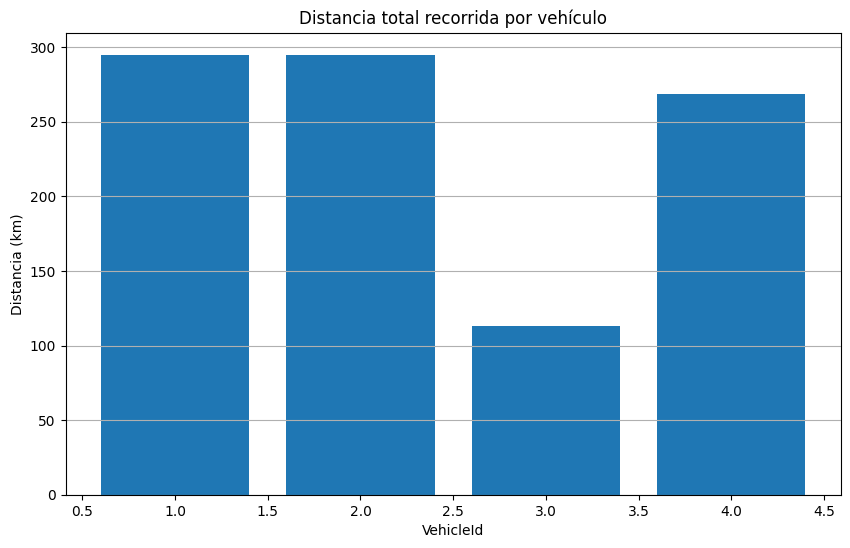

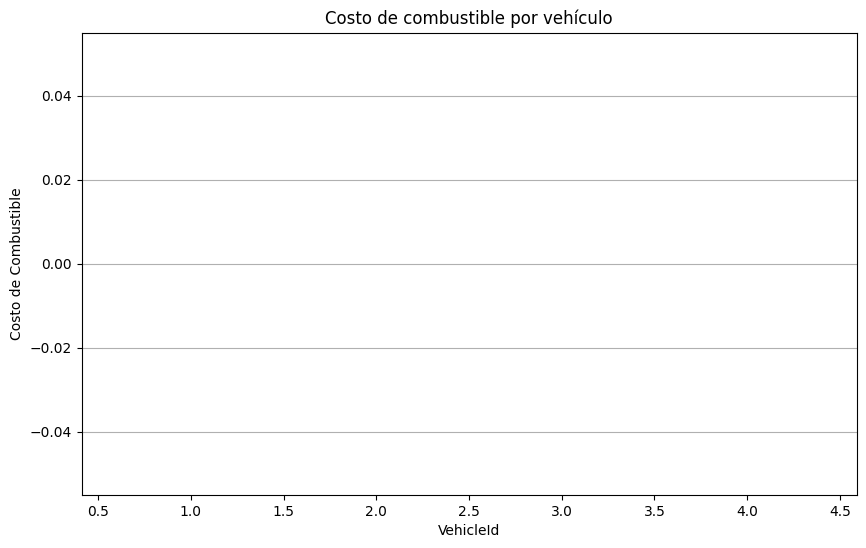

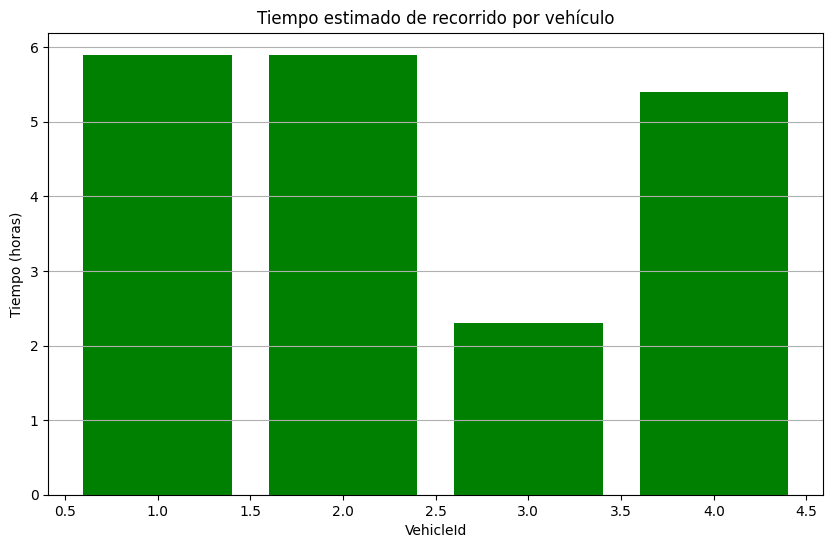

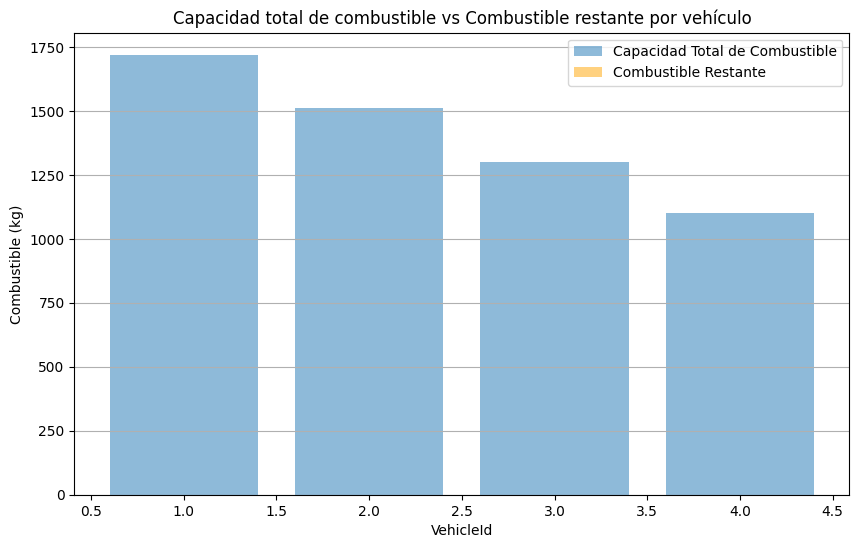

In [31]:
import matplotlib.pyplot as plt

# Cargar la verificación
df = pd.read_csv('verificacion_caso2.csv')

# --- Gráfico 1: Distancia total por vehículo ---
plt.figure(figsize=(10, 6))
plt.bar(df['VehicleId'], df['Distance'].astype(float))
plt.title('Distancia total recorrida por vehículo')
plt.xlabel('VehicleId')
plt.ylabel('Distancia (km)')
plt.grid(axis='y')
plt.show()

# --- Gráfico 2: Costo de combustible por vehículo ---
plt.figure(figsize=(10, 6))
plt.bar(df['VehicleId'], df['FuelCost'].astype(float), color='orange')
plt.title('Costo de combustible por vehículo')
plt.xlabel('VehicleId')
plt.ylabel('Costo de Combustible')
plt.grid(axis='y')
plt.show()

# --- Gráfico 3: Tiempo estimado por vehículo ---
plt.figure(figsize=(10, 6))
plt.bar(df['VehicleId'], df['Time'].astype(float), color='green')
plt.title('Tiempo estimado de recorrido por vehículo')
plt.xlabel('VehicleId')
plt.ylabel('Tiempo (horas)')
plt.grid(axis='y')
plt.show()


# --- Gráfico 4: total de combustible restante por vehículo comparado con capacidad total de combustible por vehiculo ---
plt.figure(figsize=(10, 6))
plt.bar(df['VehicleId'], df['InitFuel'].astype(float), label='Capacidad Total de Combustible', alpha=0.5)
plt.bar(df['VehicleId'], df['InitLoad'].astype(float), label='Combustible Restante', alpha=0.5, color='orange')
plt.title('Capacidad total de combustible vs Combustible restante por vehículo')
plt.xlabel('VehicleId')
plt.ylabel('Combustible (kg)')
plt.legend()
plt.grid(axis='y')
plt.show()


C:\Users\MarianaLozano\AppData\Local\Temp\ipykernel_14508\534467277.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(df_result))


Vehículo 1 -> Ruta: ['1', '4', '15', '6', '9', '8', '1']
Coordenadas encontradas: [(5, -75), (np.float64(6.56366296493606), np.float64(-72.75302039628254)), (np.float64(4.132232521764883), np.float64(-72.19806226419516)), (np.float64(6.949855824363647), np.float64(-74.44504186791264)), (np.float64(5.0), np.float64(-76.0)), (np.float64(5.867767478235116), np.float64(-75.80193773580484)), (5, -75)]
Vehículo 2 -> Ruta: ['1', '3', '11', '7', '14', '1']
Coordenadas encontradas: [(5, -75), (np.float64(5.867767478235116), np.float64(-72.19806226419516)), (np.float64(3.4363370350639406), np.float64(-75.24697960371746)), (np.float64(6.56366296493606), np.float64(-75.24697960371746)), (np.float64(3.43633703506394), np.float64(-72.75302039628254)), (5, -75)]
Vehículo 3 -> Ruta: ['1', '2', '5', '1']
Coordenadas encontradas: [(5, -75), (np.float64(5.0), np.float64(-72.0)), (np.float64(6.949855824363647), np.float64(-73.55495813208736)), (5, -75)]
Vehículo 4 -> Ruta: ['1', '10', '12', '13', '1']
Coo

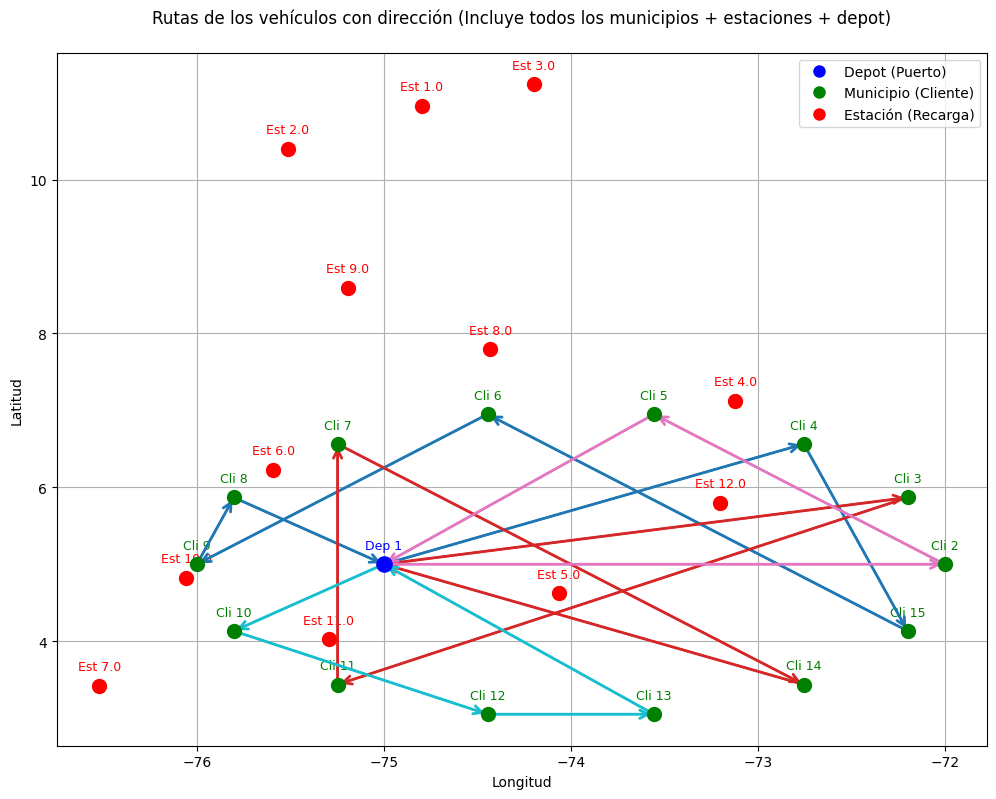

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D  # Para la leyenda personalizada

# === Cargar datos ===
stations = pd.read_csv('Datos/stations2.csv')
clients = pd.read_csv('Datos/clients2.csv')
depots = pd.read_csv('Datos/depots2.csv')
df_result = pd.read_csv('verificacion_caso2.csv')

# Crear un diccionario: nodo -> (lat, lon)
node_coords = {}

# Estaciones (con coordenadas reales)
for idx, row in stations.iterrows():
    node_coords[str(row['EstationID'])] = (row['Latitude'], row['Longitude'])

# Clientes (no tienen coordenadas reales: les asignamos posiciones ficticias)
angle_step = 2 * np.pi / len(clients)
for i, (idx, row) in enumerate(clients.iterrows()):
    angle = i * angle_step
    # Los ponemos en un círculo alrededor del depot para visualización
    lat = 5 + np.sin(angle) * 2
    lon = -74 + np.cos(angle) * 2
    node_coords[str(row['LocationID'])] = (lat, lon)

# Depots (puertos), igual: posiciones ficticias si no hay coordenadas
for idx, row in depots.iterrows():
    depot_id = str(row['DepotID'])
    node_coords[depot_id] = (5, -75)  # punto central

# Crear figura
plt.figure(figsize=(12, 9))

# Dibujar las estaciones, municipios y depot (TODOS aunque no estén en la ruta)
for idx, row in depots.iterrows():
    node_id = str(row['DepotID'])
    lat, lon = node_coords[node_id]
    plt.scatter(lon, lat, c='blue', s=120, zorder=5)
    plt.text(lon, lat + 0.2, f'Dep {node_id}', fontsize=9, ha='center', color='blue')

for idx, row in clients.iterrows():
    node_id = str(row['LocationID'])
    lat, lon = node_coords[node_id]
    plt.scatter(lon, lat, c='green', s=100, zorder=5)
    plt.text(lon, lat + 0.2, f'Cli {node_id}', fontsize=9, ha='center', color='green')

for idx, row in stations.iterrows():
    node_id = str(row['EstationID'])
    lat, lon = node_coords[node_id]
    plt.scatter(lon, lat, c='red', s=100, zorder=5)
    plt.text(lon, lat + 0.2, f'Est {node_id}', fontsize=9, ha='center', color='red')

# Dibujar las rutas con flechas (solo lo que sale del CSV)
colors = plt.cm.get_cmap('tab10', len(df_result))

for idx, row in df_result.iterrows():
    route = row['RouteSequence'].split('-')
    route_coords = []
    for node in route:
        if node in node_coords:
            route_coords.append(node_coords[node])

    print(f"Vehículo {row['VehicleId']} -> Ruta: {route}")
    print(f"Coordenadas encontradas: {route_coords}")

    if len(route_coords) >= 2:
        lats, lons = zip(*route_coords)
        plt.plot(lons, lats, marker='o', label=f'Vehículo {row["VehicleId"]}', color=colors(idx), zorder=3)

        # Flechas para cada arco
        for i in range(len(route_coords)-1):
            start = route_coords[i]
            end = route_coords[i+1]
            plt.annotate(
                '', xy=(end[1], end[0]), xytext=(start[1], start[0]),
                arrowprops=dict(arrowstyle='->', color=colors(idx), lw=2),
                size=15,
                zorder=4
            )

# Añadir leyenda personalizada
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Depot (Puerto)', markerfacecolor='blue', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Municipio (Cliente)', markerfacecolor='green', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Estación (Recarga)', markerfacecolor='red', markersize=10)
]

plt.legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.title('Rutas de los vehículos con dirección (Incluye todos los municipios + estaciones + depot)\n')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.grid(True)
plt.show()
